In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
#Librerias
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import load_model

from keras.initializers import he_uniform

from tensorflow.keras.optimizers import RMSprop


In [29]:
#Dataset todos pacientes
data = pd.read_csv('/content/gdrive/MyDrive/Proyecto_de_grado/SUSTENTACION3.0/FinalX3/TODOS/my_alladult_data.csv')

print(f"El archivo se ha cargado correctamente. Tiene {data.shape[0]} filas y {data.shape[1]} columnas.")

El archivo se ha cargado correctamente. Tiene 294195 filas y 3 columnas.


In [30]:
#ignore_index=True
data = data.reset_index(drop=True)

In [31]:
# Reorganizar los datos en forma de secuencia
def to_sequences(data,  seq_size_input, seq_size_output):
    X = []
    y = []

    for i in range(len(data)-seq_size_input-seq_size_output+1):
        X.append(data[i:(i+seq_size_input), 0:2])
        y.append(data[(i+seq_size_input):(i+seq_size_input+seq_size_output), 2])

    return np.array(X), np.array(y)

In [32]:
#### Datos de entrenamiento y datos de prueba
train_size = int(len(data) * 0.7)

train_data = data.iloc[:train_size, :] # 70% entrenamiento
test_data = data.iloc[train_size:, :] # 30% prueba

test_data = test_data.reset_index(drop=True)

#### Los indices donde hay ingestas
posicionestrain = train_data.loc[train_data.iloc[:, 0] != 0].index
posicionestest = test_data.loc[test_data.iloc[:, 0] != 0].index

df_posiciones_train = pd.DataFrame(posicionestrain)
df_posiciones_test = pd.DataFrame(posicionestest)


#### Crear una lista para almacenar las muestras donde estan las curvas de glucosa para el entrenamiento
cumplen_train = []

for i in range(1, len(df_posiciones_train)): # Comparar los elementos de la posición anterior con los elementos siguientes
    anterior = df_posiciones_train.iloc[i-1, 0]  # Obtener el elemento anterior de la segunda columna
    siguiente = df_posiciones_train.iloc[i, 0]  # Obtener el elemento actual de la segunda columna

    if siguiente >= 10 + anterior:
        cumplen_train.append(anterior)

ultimo_elemento_train = df_posiciones_train.iloc[-1]

cumplen_train.extend(ultimo_elemento_train.tolist())# Unir el último elemento a la otra lista

print('Posiciones donde hay curvas de glucosa, en el entrenamiento: \n',cumplen_train) # Imprimir la lista de valores anteriores que cumplen la condición
print('Numero de curvas: \n',len(cumplen_train)) #Imprimir el tamaño la lista o numero de curvas

#### Crear una lista para almacenar las muestras donde estan las curvas de glucosa para las pruebas
cumplen_test = []

for i in range(1, len(df_posiciones_test)): # Comparar los elementos de la posición anterior con los elementos siguientes
    anterior = df_posiciones_test.iloc[i-1, 0]  # Obtener el elemento anterior de la segunda columna
    siguiente = df_posiciones_test.iloc[i, 0]  # Obtener el elemento actual de la segunda columna

    if siguiente >= 10 + anterior:
        cumplen_test.append(anterior)

ultimo_elemento_test = df_posiciones_test.iloc[-1]

cumplen_test.extend(ultimo_elemento_test.tolist()) # Unir el último elemento a la otra lista

print('Posiciones donde hay curvas de glucosa, en las pruebas: \n',cumplen_test) # Imprimir la lista de valores anteriores que cumplen la condición

print('Numero de curvas: \n',len(cumplen_test))

#### Preprocesar los datos, escoger la insulina y glucosa de entrada, tambien glucosa salida
X_train = train_data.iloc[:, 1:3].values
y_train = train_data.iloc[:,2].values

X_test = test_data.iloc[:, 1:3].values
y_test = test_data.iloc[:, 2].values

#### Normalizar los datos
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Normalizar y_train
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
y_test = sc_y.transform(y_test.reshape(-1, 1))

#CON LOS DATOS NORMALIZADOS
seq_size_input = 15
seq_size_output = 210
X_train, y_train = to_sequences(np.hstack((X_train, y_train)), seq_size_input, seq_size_output)
X_test, y_test = to_sequences(np.hstack((X_test, y_test)), seq_size_input, seq_size_output)
print('Secuencia y_train: \n', y_train.shape)
print('Secuencia X_train: \n', X_train.shape)
print('Secuencia X_train: \n', y_test.shape)
print('Secuencia X_train: \n', X_test.shape)

#### Los paso a dataframe para poder elegir las secuencias de las curvas
flattened_data = np.reshape(X_train, (X_train.shape[0], -1))
df_X_train = pd.DataFrame(flattened_data)

flattened_test = np.reshape(X_test, (X_test.shape[0], -1))
df_X_test = pd.DataFrame(flattened_test)

df_y_train = pd.DataFrame(y_train)
df_y_test = pd.DataFrame(y_test)

#### Filtrar el dataframe para mantener solo las filas especificadas
df_X_train_seleccionado = df_X_train[df_X_train.index.isin(cumplen_train)]
df_y_train_seleccionado = df_y_train[df_y_train.index.isin(cumplen_train)]
df_X_test_seleccionado = df_X_test[df_X_test.index.isin(cumplen_test)]
df_y_test_seleccionado = df_y_test[df_y_test.index.isin(cumplen_test)]

Posiciones donde hay curvas de glucosa, en el entrenamiento: 
 [499, 878, 1376, 1990, 2369, 2865, 3482, 3857, 4350, 4962, 5344, 5840, 6458, 6832, 7326, 7941, 8321, 8815, 9429, 9809, 10304, 10920, 11305, 11797, 12413, 12789, 13281, 13895, 14274, 14766, 15382, 15755, 16247, 16861, 17241, 17731, 18346, 18729, 19220, 19833, 20216, 20714, 21326, 21708, 22207, 22819, 23199, 23691, 24307, 24687, 25179, 25796, 26172, 26660, 27270, 27648, 28140, 28753, 29131, 29630, 30296, 30664, 31160, 31776, 32155, 32642, 33263, 33648, 34136, 34758, 35126, 35622, 36240, 36617, 37103, 37719, 38085, 38583, 39200, 39583, 40070, 40682, 41057, 41552, 42165, 42544, 43032, 43647, 44014, 44501, 45113, 45488, 45985, 46597, 46964, 47452, 48068, 48455, 48942, 49559, 49927, 50416, 51035, 51403, 51890, 52504, 52883, 53371, 53987, 54353, 54849, 55464, 55839, 56327, 56946, 57313, 57801, 58416, 58782, 59268, 59896, 60261, 60742, 61343, 61704, 62185, 62786, 63147, 63628, 64229, 64590, 65071, 65672, 66033, 66514, 67115, 67476,

Grafica de los datos del dataset


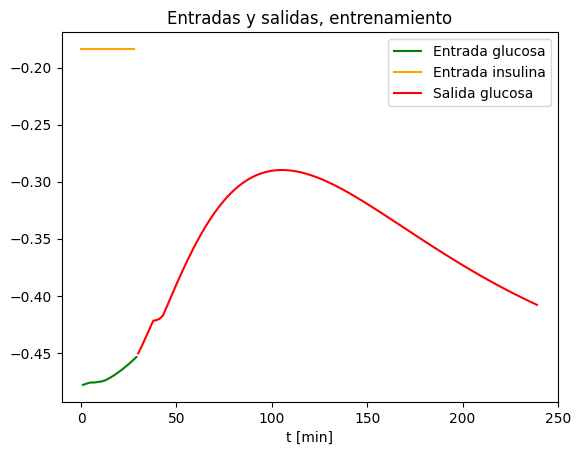

In [33]:
print('Grafica de los datos del dataset')
#plt.plot(data.index, data.iloc[:,2], color='green', label='Glucosa')

Numerocurva = 1

plt.plot(df_X_train_seleccionado.iloc[Numerocurva, 1::2],color='green',label='Entrada glucosa') #Para mostrar solo la glucosa
plt.plot(df_X_train_seleccionado.iloc[Numerocurva, ::2],color='orange',label='Entrada insulina') #Para mostrar solo la glucosa
plt.plot(range(seq_size_input*2, seq_size_output + seq_size_input*2),df_y_train_seleccionado.iloc[Numerocurva,:], color='red',label='Salida glucosa')
plt.title('Entradas y salidas, entrenamiento')
plt.xlabel('t [min]')
#plt.ylabel('Valor de la glucosa')
plt.legend()
plt.xlim([-10, 250])
#plt.ylim([185, 190])
plt.show()
print('')

In [34]:
X_train = df_X_train_seleccionado.values
y_train = df_y_train_seleccionado.values
X_test = df_X_test_seleccionado.values
y_test = df_y_test_seleccionado.values

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)


(421, 210)
(421, 30)
(177, 210)
(177, 30)


In [35]:
X_train = np.reshape(X_train, (len(X_train), seq_size_input, 2))

X_test = np.reshape(X_test, (len(X_test), seq_size_input, 2))
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(421, 210)
(421, 15, 2)
(177, 210)
(177, 15, 2)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60)                15120     
                                                                 
 dense_10 (Dense)            (None, 210)               12810     
                                                                 
Total params: 27,930
Trainable params: 27,930
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 1.1926 
Epoch 1: val_loss improved from inf to 0.10828, saving model to modelo-1.h5
11/11 [==============================] - 2s 47ms/step - loss: 1.1759 - val_loss: 0.1083
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.8393
Epoch 2: val_loss improved from 0.10828 to 0.04994, saving model to modelo-1.h5
11/11 [==============================] - 0s

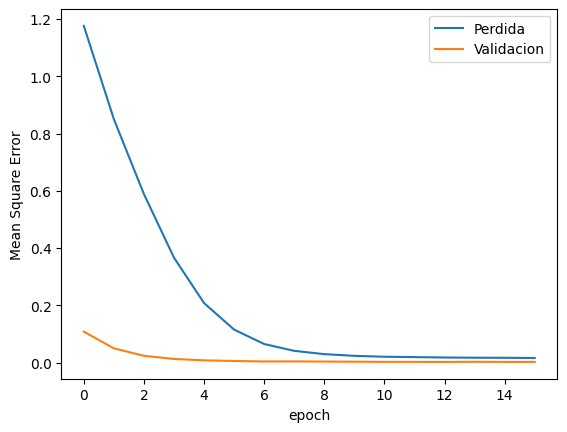

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 60)                15120     
                                                                 
 dense_11 (Dense)            (None, 210)               12810     
                                                                 
Total params: 27,930
Trainable params: 27,930
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 1.2769 
Epoch 1: val_loss improved from inf to 0.09295, saving model to modelo-2.h5
11/11 [==============================] - 2s 47ms/step - loss: 1.2556 - val_loss: 0.0929
Epoch 2/100
 8/11 [====================>.........] - ETA: 0s - loss: 1.0491
Epoch 2: val_loss improved from 0.09295 to 0.04549, saving model to modelo-2.h5
11/11 [==============================] - 0s

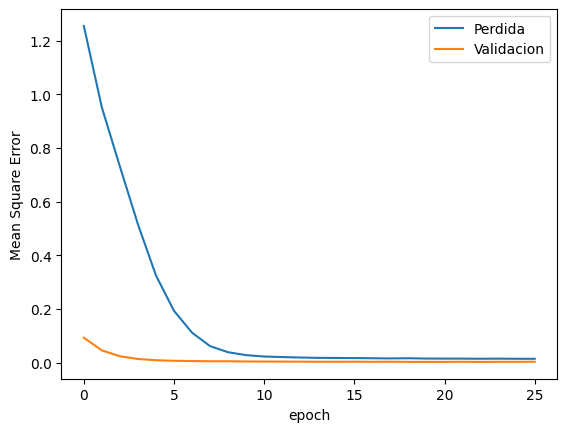

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60)                15120     
                                                                 
 dense_12 (Dense)            (None, 210)               12810     
                                                                 
Total params: 27,930
Trainable params: 27,930
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 1.1370 
Epoch 1: val_loss improved from inf to 0.10274, saving model to modelo-3.h5
11/11 [==============================] - 2s 48ms/step - loss: 1.1544 - val_loss: 0.1027
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.8891
Epoch 2: val_loss improved from 0.10274 to 0.04882, saving model to modelo-3.h5
11/11 [==============================] - 0s

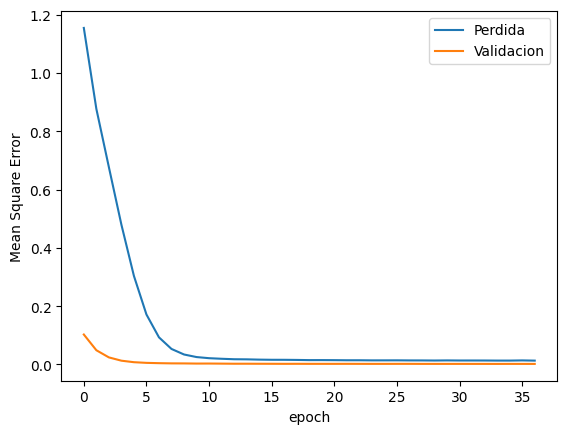

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 60)                15120     
                                                                 
 dense_13 (Dense)            (None, 210)               12810     
                                                                 
Total params: 27,930
Trainable params: 27,930
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 1.2266 
Epoch 1: val_loss improved from inf to 0.08214, saving model to modelo-4.h5
11/11 [==============================] - 2s 45ms/step - loss: 1.2261 - val_loss: 0.0821
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.8583
Epoch 2: val_loss improved from 0.08214 to 0.04296, saving model to modelo-4.h5
11/11 [==============================] - 0s

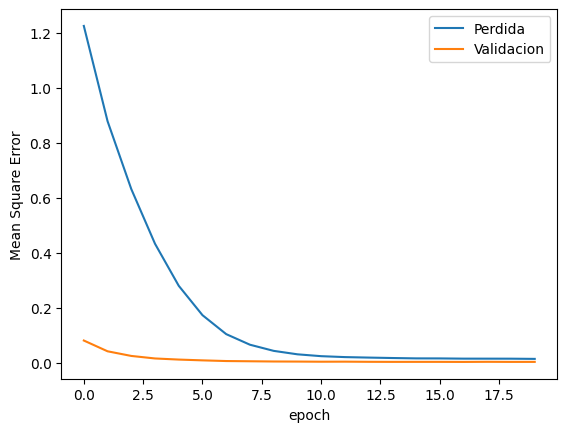

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60)                15120     
                                                                 
 dense_14 (Dense)            (None, 210)               12810     
                                                                 
Total params: 27,930
Trainable params: 27,930
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.1851 
Epoch 1: val_loss improved from inf to 4.41444, saving model to modelo-5.h5
11/11 [==============================] - 2s 45ms/step - loss: 0.1724 - val_loss: 4.4144
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.0621
Epoch 2: val_loss improved from 4.41444 to 4.19737, saving model to modelo-5.h5
11/11 [==============================] - 0s

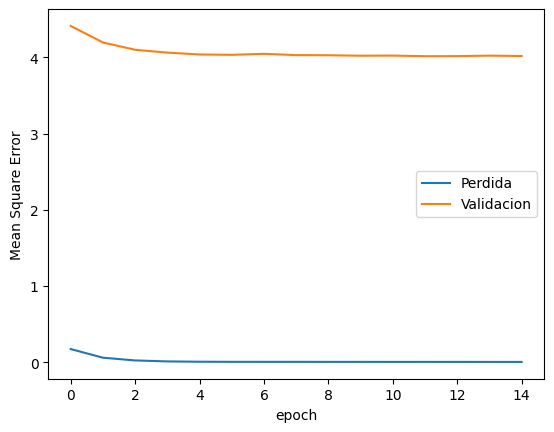

In [36]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
KFold(n_splits=5, random_state=None, shuffle=False)


# Crear listas para almacenar los valores del "average loss" de entrenamiento y validación en cada pliegue
train_losses = []
val_losses = []

#Para guardar el mejor modelo
best_loss = float('inf')
best_model_path = ""

for i, (train_index, test_index) in enumerate(kf.split(X_train,y_train)):
  model = Sequential()
  model.add(LSTM(60, activation='tanh', input_shape=(seq_size_input, 2), kernel_initializer=he_uniform()))
  model.add(Dense(seq_size_output, activation='linear', kernel_initializer=he_uniform()))


  model.compile(optimizer=RMSprop(), loss='mse')
  print(model.summary())

  filepath = f"modelo-{i+1}.h5"
  early_stop = EarlyStopping(monitor='val_loss', patience=3)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

  X, y =  X_train[train_index], y_train[train_index]
  X_val, y_val = X_train[test_index], y_train[test_index]


  history = model.fit(X, y, epochs=100, batch_size=32,validation_data=(X_val, y_val),callbacks=[checkpoint, early_stop] )

  mediamse = np.mean( history.history['loss'] )
  stdmse = np.std(  history.history['loss'])
  print('')
  print(f" La media del mse, {i}-fold es : {mediamse}")
  print('')
  print(f" La desviacion estandar del mse, {i}-fold es : {stdmse}")

  # Obtener los valores de "average loss" para el pliegue actual
  fold_train_losses = model.history.history['loss']
  fold_val_losses = model.history.history['val_loss']

  # Almacenar los valores de "average loss" para el pliegue actual
  train_losses.append(fold_train_losses)
  val_losses.append(fold_val_losses)

  if min(fold_val_losses) < best_loss:
        best_loss = min(fold_val_losses)
        best_model_path = filepath

  history.history.keys() # aqui me muestra que esta guardando, con history me guarda todos los valores que calcula durante el proceso de entrenamiento

  # vamos a graficar
  plt.plot(history.history['loss'], label='Perdida') # Grafico esta para ver si estoy sobre entrenando
  plt.plot(history.history['val_loss'], label='Validacion') # Grafico esta para ver si estoy sobre entrenando
  plt.xlabel('epoch')
  plt.ylabel('Mean Square Error')
  plt.legend()
  plt.show()



In [37]:
# rellenar de ceros los espacios vacios de la lista con loss y validation

df_train_losses = pd.DataFrame(train_losses)

df_filled_train_losses = df_train_losses.fillna(0)

train_losses_completa = df_filled_train_losses.values.tolist()

df_val_losses = pd.DataFrame(val_losses)

df_filled_val_losses = df_val_losses.fillna(0)

val_losses_completa = df_filled_val_losses.values.tolist()


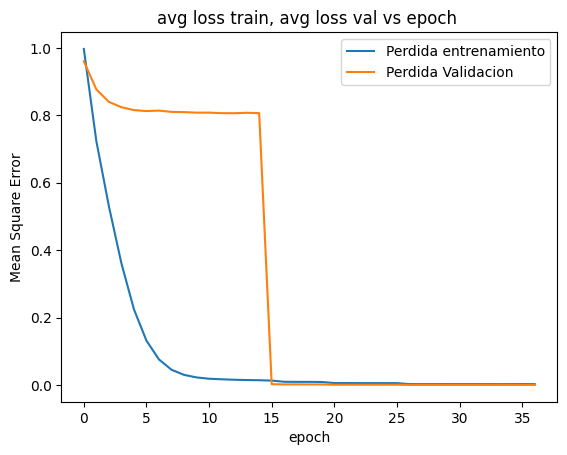

In [38]:

# Calcular el promedio de "average loss" para todos los pliegues y épocas
avg_train_losses = np.mean(train_losses_completa, axis=0)
avg_val_losses = np.mean(val_losses_completa, axis=0)

# vamos a graficar
plt.plot(avg_train_losses, label='Perdida entrenamiento') # Grafico esta para ver si estoy sobre entrenando
plt.plot(avg_val_losses, label='Perdida Validacion') # Grafico esta para ver si estoy sobre entrenando
plt.title('avg loss train, avg loss val vs epoch ')
plt.xlabel('epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

In [39]:
# Cargar el mejor modelo
best_model = load_model(best_model_path)

In [40]:
# Seleccionar una secuencia específica
index = 0
input_sequence = X_test[index]

# Hacer la predicción
y_pred = best_model.predict(np.expand_dims(input_sequence, axis=0))
# usamos el np.expand_dims() para agregar una dimensión adicional al inicio de input_sequence
print(y_pred.shape)


1/1 [==============================] - 0s 328ms/step
(1, 210)


In [41]:
# Desenrollar X_test para convertirlo en un array bidimensional
X_test_flattened = X_test.reshape(-1, X_test.shape[-1])

# Aplicar la transformación inversa utilizando el objeto StandardScaler
X_test_desnormalizado = sc.inverse_transform(X_test_flattened)

# Volver a darle forma a X_test_desnormalizado a su forma original
X_test = X_test_desnormalizado.reshape(X_test.shape)

# Desnormalizar los datos
y_pred = sc_y.inverse_transform(y_pred)

y_test = sc_y.inverse_transform(y_test)

print(y_pred.shape)
print(y_test.shape)
print(X_test.shape)

(1, 210)
(177, 210)
(177, 15, 2)


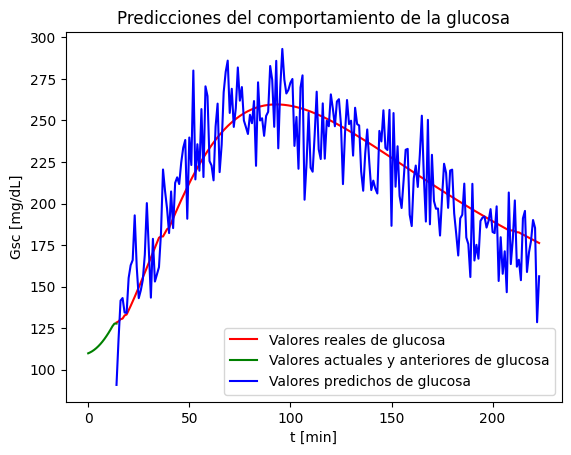

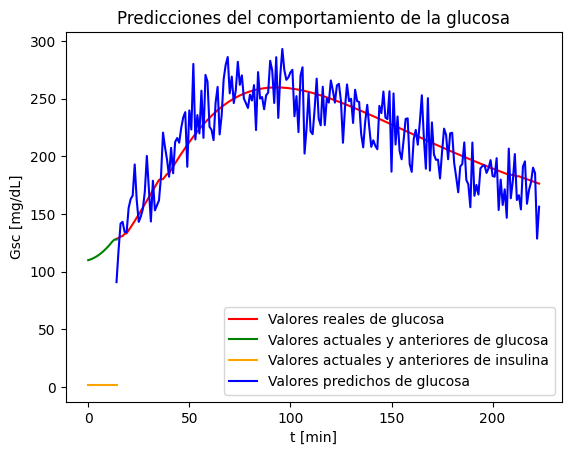

In [42]:
# Grafica del comportamiento de la glucosa en el desayuno del dia 15
plt.plot(range(seq_size_input-1, seq_size_input-1+seq_size_output),y_test[0,:],color='red', label='Valores reales de glucosa')
plt.plot(X_test[0,:,1],color='green', label='Valores actuales y anteriores de glucosa')
plt.plot(range(seq_size_input-1, seq_size_input-1+seq_size_output),y_pred[0,:],color='blue', label='Valores predichos de glucosa')
plt.title('Predicciones del comportamiento de la glucosa')
plt.xlabel('t [min]')
plt.ylabel('Gsc [mg/dL]')
plt.legend()
plt.show()

print('')
# Grafica del comportamiento de la glucosa en el desayuno del dia 15
plt.plot(range(seq_size_input-1, seq_size_input-1+seq_size_output),y_test[0,:],color='red', label='Valores reales de glucosa')
plt.plot(X_test[0,:,1],color='green', label='Valores actuales y anteriores de glucosa')
plt.plot(X_test[0,:,0],color='orange', label='Valores actuales y anteriores de insulina')
plt.plot(range(seq_size_input-1, seq_size_input-1+seq_size_output),y_pred[0,:],color='blue', label='Valores predichos de glucosa')
plt.title('Predicciones del comportamiento de la glucosa')
plt.xlabel('t [min]')
plt.ylabel('Gsc [mg/dL]')
plt.legend()
plt.show()

In [43]:
# Definir la matriz que contiene la curva
#fila_curva =  X_train[0,:,1] # Ejemplo de matriz con 3 filas

fila_curva =  y_test[0,:] # Ejemplo de matriz con 3 filas

# Restarle la glucosa basal a cada elemento del array
for i in range(len(fila_curva)):
    fila_curva[i] -= 105

# Calcular el área bajo la curva usando la regla del trapecio
xx = np.arange(len(fila_curva))  # Valores x
yy = fila_curva  # Valores y
area = np.trapz(yy, xx)

arear = (area*15)/1000

print("El área bajo la curva es:", arear)

El área bajo la curva es: 349.83


In [44]:
# Definir la matriz que contiene la curva
#fila_curva =  X_train[0,:,1] # Ejemplo de matriz con 3 filas

fila_curva =  y_pred[0,:] # Ejemplo de matriz con 3 filas

# Restarle la glucosa basal a cada elemento del array
for i in range(len(fila_curva)):
    fila_curva[i] -= 105

# Calcular el área bajo la curva usando la regla del trapecio
xx = np.arange(len(fila_curva))  # Valores x
yy = fila_curva  # Valores y
area = np.trapz(yy, xx)

arear = (area*15)/1000

print("El área bajo la curva es:", arear)

El área bajo la curva es: 347.95388746261597


In [45]:
# Media MSE y desviacion estandar MSE de las prediciones con la escala normal
mse = mean_squared_error(y_test[0,:].flatten(), y_pred.flatten())
std = np.sqrt(mse)
mediamse = np.mean(mse)

print('La media MSE:',mediamse)
print('La desviacion standar MSE', std)

# calcular la MAE
mae = mean_absolute_error(y_test[0,:], y_pred[0,:])
print('MAE:', mae)

# calcular la RMSE
rmse = np.sqrt(mean_squared_error(y_test[0,:], y_pred[0,:]))
print('RMSE:', rmse)

La media MSE: 418.9247796645094
La desviacion standar MSE 20.467652031058897
MAE: 16.825728640601753
RMSE: 20.467652031058897
